<a href="https://colab.research.google.com/github/riskoptima/blog/blob/master/BacktestExcel_backup2022_03_28%40Commodities%2BCC_iyi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
import numpy # for dot product
import pandas # for excel operations
import openpyxl
import pickle
from datetime import datetime # for formatting the dates
from pandas.core.common import flatten # for flattening the beta confidence values
from statsmodels.tsa.vector_ar.vecm import coint_johansen # for the cointegration tests
from statsmodels.tsa.vector_ar.vecm import VECM # for the cointegration model
from random import sample # for sampling a sublist of a list
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests

**Step 1:** Test each of the time-series to determine their order of integration. Ideally, this should involve using a test (such as the ADF test) for which the null hypothesis is non-stationarity; as well as a test (such as the KPSS test) for which the null is stationarity. It’s good to have a cross-check

In [136]:
data = pandas.read_excel('Commodities_weekly.xlsx',index_col=0);
#data = data.iloc[445:, :15]
data = data.iloc[:,:14]
print(data)
data.index = pandas.to_datetime(data.index)
data = data.dropna()

            Aliminum   Crude Oil      Cotton         Gold  Copper  \
Date                                                                
2018-01-01   2244.50   61.439999   78.010002  1320.300049  3.2070   
2018-01-08   2244.50   64.300003   81.680000  1333.400024  3.2000   
2018-01-15   2244.50   63.369999   83.419998  1331.900024  3.1670   
2018-01-22   2244.50   66.139999   80.480003  1351.599976  3.1825   
2018-01-29   2250.00   65.449997   77.300003  1333.699951  3.1765   
...              ...         ...         ...          ...     ...   
2022-02-21   3406.00   91.589996  122.120003  1886.500000  4.4720   
2022-02-28   3873.00  115.680000  120.199997  1965.099976  4.9290   
2022-03-07   3446.50  109.330002  121.029999  1982.699951  4.6160   
2022-03-14   3357.25  104.699997  126.860001  1928.199951  4.7305   
2022-03-21   3593.50  112.339996  130.899994  1961.599976  4.7290   

            Heating Oil  Natural Gas    Palladium     Platinum  Gasoline  \
Date                      

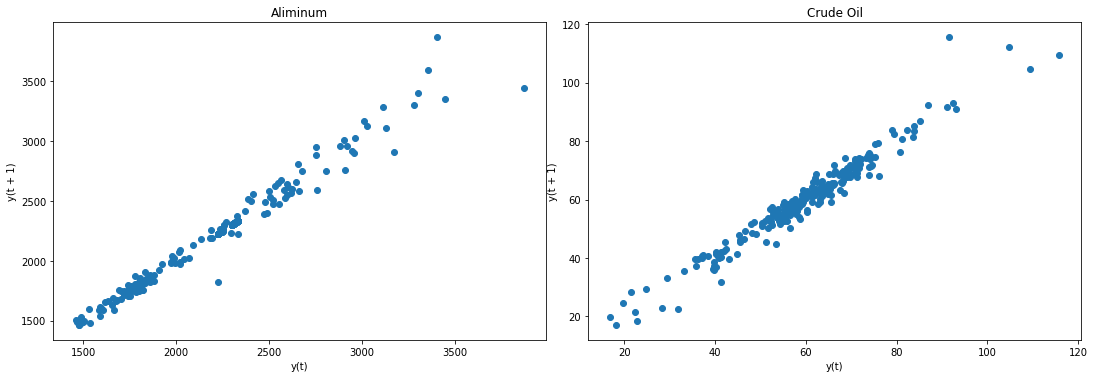

In [137]:
from pandas.plotting import lag_plot
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(data[data.columns[0]], ax=ax4)
ax4.set_title(data.columns[0]);

lag_plot(data[data.columns[1]], ax=ax5)
ax5.set_title(data.columns[1]);

plt.show()

Result: Data is not stationary. We will have to make it stationary using difference operation

In [138]:
level_data = data.copy(deep=True)

for col in data.columns:
  data[col] = data[col].diff(1)
data = data.dropna()

#for col in data.columns:
#  data[col] = data[col].diff(1)
#data = data.dropna()

Split data into train and test. We will need this later for VAR analysis

In [139]:
train = data.iloc[:round(len(data)*0.8),:]
test = data.iloc[round(len(data)*0.8):,:]

In [140]:
train.tail()

,Aliminum,Crude Oil,Cotton,Gold,Copper,Heating Oil,Natural Gas,Palladium,Platinum,Gasoline,Silver,Corn,Soybean,Wheat
Date,,,,,,,,,,,,,,
2021-04-19,45.00,-0.990002,3.800003,-2.000000,0.163,-0.0222,0.050,82.300049,24.300049,-0.0442,-0.022001,70.00,106.50,57.75
2021-04-26,40.50,1.440002,-0.080002,-9.699951,0.136,0.0476,0.201,73.199951,-21.099976,0.0741,-0.223999,84.50,31.25,32.25
2021-05-03,142.25,1.320000,2.230003,63.799927,0.287,0.0895,0.027,4.200195,42.900024,0.0571,1.608999,32.75,50.00,31.00
2021-05-10,-79.50,0.470001,-7.230003,6.800049,-0.102,0.0256,0.003,-37.500000,-31.500000,-0.0003,-0.108999,-87.75,-17.25,-46.25
2021-05-17,-87.25,-1.790001,0.389999,38.799927,-0.168,-0.0480,-0.055,-116.300049,-53.000000,-0.0581,0.119999,-25.50,-77.50,-53.00


In [141]:
test.head()

,Aliminum,Crude Oil,Cotton,Gold,Copper,Heating Oil,Natural Gas,Palladium,Platinum,Gasoline,Silver,Corn,Soybean,Wheat
Date,,,,,,,,,,,,,,
2021-05-24,131.00,2.739998,-0.699997,25.800049,0.1865,0.0563,0.080,-26.800049,30.599976,0.0717,0.520000,-2.75,4.25,-10.75
2021-05-31,-41.25,3.300003,3.680000,-12.699951,-0.1450,0.0754,0.111,89.399902,-35.200073,0.0713,-0.114000,26.00,53.25,24.25
2021-06-07,10.50,1.290001,1.199997,-12.400024,0.0040,0.0008,0.199,-60.199951,-13.299927,-0.0254,0.252001,1.75,-75.25,-7.00
2021-06-14,-87.00,0.729996,-2.580002,-109.500000,-0.3790,-0.0275,-0.081,-312.000000,-109.800049,-0.0178,-2.173000,-29.25,-112.50,-18.00
2021-06-21,100.25,2.410004,2.010002,8.699951,0.1365,0.0561,0.281,167.600098,62.700073,0.0956,0.124001,-18.75,-66.25,-25.75


ADF Null hypothesis: there is a unit root, i.e. series is non-stationary

In [142]:
from statsmodels.tsa.stattools import adfuller

Xs = []
for col in data.columns:
  X = numpy.array(data[col])
  X = X[~numpy.isnan(X)]
  Xs.append(X)
  result = adfuller(X)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.851669
p-value: 0.051264
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
ADF Statistic: -7.188175
p-value: 0.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
ADF Statistic: -10.227881
p-value: 0.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
ADF Statistic: -17.615323
p-value: 0.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
ADF Statistic: -17.612917
p-value: 0.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
ADF Statistic: -6.083211
p-value: 0.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
ADF Statistic: -4.715360
p-value: 0.000079
Critical Values:
	1%: -3.462
	5%: -2.875
	10%: -2.574
ADF Statistic: -7.087136
p-value: 0.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
ADF Statistic: -17.066478
p-value: 0.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
ADF Statistic: -14.682190
p-value: 0.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
ADF Statistic: -15.958210

KPSS Null hypothesis: there are no unit roots, i.e. series is stationary

In [143]:
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

for X in Xs:
  kpss_test(X)

KPSS Statistic: 0.625063449145898
p-value: 0.02035786825946382
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
KPSS Statistic: 0.3671042842462959
p-value: 0.09133436023866556
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
KPSS Statistic: 0.590674526031103
p-value: 0.02348413399717245
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
KPSS Statistic: 0.11288674608428602
p-value: 0.1
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
KPSS Statistic: 0.4258221928454784
p-value: 0.06602491687694897
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
KPSS Statistic: 0.5002158909699759
p-value: 0.04161804257432976
num lags: 15
Critial

**Result:** ADF Null Hypothesis is rejected: Thus, data is stationary KPSS Null Hypothesis could not be rejected. Thus, data is stationary

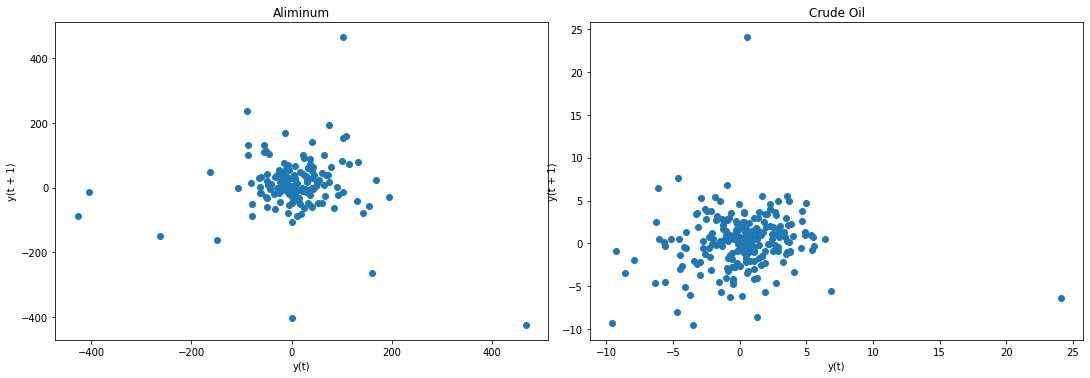

In [144]:
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(data[data.columns[0]], ax=ax4)
ax4.set_title(data.columns[0]);

lag_plot(data[data.columns[1]], ax=ax5)
ax5.set_title(data.columns[1]);

plt.show()

**Result:** lag plot is in confirmatory with ADF test and KPSS test

**Step 2:** Let the maximum order of integration for the group of time-series be m. So, if there are two time-series and one is found to be I(1) and the other is I(2), then m = 2. If one is I(0) and the other is I(1), then m = 1, etc.

**Result:** We saw above that for our case m = 1

**Step 3:** Set up a VAR model in the levels of the data, regardless of the orders of integration of the various time-series. Most importantly, you must not diff() the data, no matter what you find at Step 1.

**Step 4:** Determine the appropriate maximum lag length for the variables in the VAR, say p, using the usual methods. Specifically, base the choice of p on the usual information criteria, such as AIC, SIC.

In [145]:
# obtain the lag P for VAR
level_data = level_data.dropna()
model = VAR(level_data) #recall that level_data is w/o difference operation
for i in list(range(1, 13)):
    result = model.fit(i)
    try:
        print('Lag Order =', i)
        print('AIC:\t', result.aic)
        print('BIC:\t', result.bic)
        print('FPE:\t', result.fpe)
        print('HQIC:\t', result.hqic, '\n')
    except:
        continue

Lag Order = 1
AIC:	 32.01600218481558
BIC:	 35.255373933606464
FPE:	 80475086324915.38
HQIC:	 33.324145969087745 

Lag Order = 2
AIC:	 32.20149898405127
BIC:	 38.48443561558322
FPE:	 98729199844444.83
HQIC:	 34.73899212200587 

Lag Order = 3
AIC:	 32.23799542870783
BIC:	 41.584169868152934
FPE:	 107804629255228.83
HQIC:	 36.01305203780317 

Lag Order = 4
AIC:	 32.370001293503755
BIC:	 44.79930123878158
FPE:	 136387697090442.44
HQIC:	 37.39092384824882 

Lag Order = 5
AIC:	 32.62738603101248
BIC:	 48.159917221929426
FPE:	 210848494100827.22
HQIC:	 38.90256665355011 

Lag Order = 6
AIC:	 32.49500643182401
BIC:	 51.15109598285619
FPE:	 245105863428213.78
HQIC:	 40.03292820600622 

Lag Order = 7
AIC:	 32.0493273855443
BIC:	 53.849527183769936
FPE:	 240526461869135.7
HQIC:	 40.858565695002376 

Lag Order = 8
AIC:	 31.709236927613752
BIC:	 56.67432709734291
FPE:	 319876969991173.06
HQIC:	 41.79846081833803 

Lag Order = 9
AIC:	 30.54971550021122
BIC:	 58.70070793590385
FPE:	 247644287288053.

**Result:** The lag-order p = 1 on the basis of Akaike Information Criterion (AIC)

**Step 5:** Make sure that the VAR is well-specified. For example, ensure that there is no serial correlation in the residuals. If need be, increase p until any autocorrelation issues are resolved.

In [146]:
model = VAR(train)
model_fitted = model.fit(1)

**Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic**

The value of this statistic can vary from 0 to 4. The closer it is to 2, there is less significant serial correlation. The closer it is to 0, there is a positive serial correlation, and being close to 4 implies negative serial correlation.

In [147]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(data.columns, out):
    print(col, ':', round(val, 2))

Aliminum : 1.92
Crude Oil : 1.99
Cotton : 2.04
Gold : 1.99
Copper : 2.05
Heating Oil : 2.01
Natural Gas : 1.99
Palladium : 2.01
Platinum : 2.06
Gasoline : 2.06
Silver : 2.0
Corn : 1.94
Soybean : 1.94
Wheat : 2.0


**Result:** There is no significant correlation between in the residuals

**Step 6:** If two or more of the time-series have the same order of integration, at Step 1, then test to see if they are cointegrated, preferably using Johansen’s methodology (based on your VAR) for a reliable result.

In [148]:
# I could not perform Johansen's test. Instead I check for co-integration using t-statistics (author's note)

import statsmodels.tsa.stattools as ts 
result = ts.coint(data[data.columns[0]], data[data.columns[1]])
print(result)

(-4.151760740568442, 0.004311436722576777, array([-3.94714772, -3.36417226, -3.06387292]))


**Result:** The p-value (tuple's middle element) < 0.05. Thus rejecting the null hypothesis, they are cointegrated.

**Step 7:** No matter what you conclude about cointegration at Step 6, this is not going to affect what follows. It just provides a possible cross-check on the validity of your results at the very end of the analysis.

**Step 8:** Now take the preferred VAR model and add in m additional lags of each of the variables into each of the equations.

In [149]:
model = VAR(train)
model_fitted = model.fit(1)
#get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

1


**Step 9** and **Step 10:** Test for Granger non-causality. It’s essential that you don’t include the coefficients for the ‘extra’ m lags when you perform the tests. They are there just to fix up the asymptotics.

In [150]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 220 entries, 2018-01-08 to 2022-03-21
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Aliminum     220 non-null    float64
 1   Crude Oil    220 non-null    float64
 2   Cotton       220 non-null    float64
 3   Gold         220 non-null    float64
 4   Copper       220 non-null    float64
 5   Heating Oil  220 non-null    float64
 6   Natural Gas  220 non-null    float64
 7   Palladium    220 non-null    float64
 8   Platinum     220 non-null    float64
 9   Gasoline     220 non-null    float64
 10  Silver       220 non-null    float64
 11  Corn         220 non-null    float64
 12  Soybean      220 non-null    float64
 13  Wheat        220 non-null    float64
dtypes: float64(14)
memory usage: 25.8 KB


Weed out the columns and return a dictionary {instrument_i:coefficient_i} for the prescribed data slice.

In [151]:
def weed_out(data, bad, det_order = -1, k_ar_diff = 1):
  n = data.shape[1] # number of trading instruments
  if n <= 2 or ' '.join(list(data.columns)) in bad:
    return False # if there are too few columns or this column is already tried

  coint = coint_johansen(data, det_order = det_order, k_ar_diff = k_ar_diff) # get the cointegration tests
  compare1 = coint.lr1[0] >= coint.cvt[0, 1] # trace statistics test
  compare2 = coint.lr2[0] >= coint.cvm[0, 1] # eigenvalue test

  model = VECM(data, coint_rank = 1, deterministic = "n", k_ar_diff = k_ar_diff).fit() # cointegration model
  
  beta = list(flatten(model.beta)) # cointegration model's beta values
  beta_dict = {model.names[i]: beta[i] for i in range(n)}

  stderr = list(flatten(model.stderr_beta))
  diff = {model.names[i]:abs(beta[i]) - 2 * abs(stderr[i]) for i in range(len(model.names))}

  min_diff = min(diff.values())

  if min_diff >= 0 and compare1 and compare2:
    return beta_dict # no problematic column
  else:
    for instrument in diff: # test each instrument seperately
      if diff[instrument] < 0: # if difference < 0 
        copy = data.copy().drop(columns=instrument) # get a copy of the data without the problematic column
        alt = weed_out(copy, bad) # run again
        if alt != False:
          return alt
        bad.add(' '.join(copy.columns))
  print('No result for', data.columns)
  return False

Find the cointegration coefficients for a slice of a data frame.

In [152]:
def get_coefficients(data, start, end, bad, det_order = -1, k_ar_diff = 0):
  return weed_out(data.iloc[start:end, :].copy(deep=True), bad)

I wanted to ignore the frequency warning because it hid the necessary information I wanted to see. This is ideally to be removed.

In [153]:
import warnings
warnings.filterwarnings("ignore")

In [154]:
Rows = data.shape[0]
Columns = data.shape[1]

print(Rows,Columns)

220 14


Create the report of the source data given the lengths of training, testing, and the repetition interval. Report the evolution of the fund given the initial capital.

Entry = 1 length = 1 day 0 coefficients: [1.0, 0, 2.914984206572745, -2.1617959615533, 0, 0, -35.28061366281798, 0, 0.46950494837933354, -147.1340777823119, 50.58722450152198, 2.060066982002499, 0, -1.3996336569948995]
No result for Index(['Aliminum', 'Crude Oil', 'Cotton', 'Gold', 'Copper', 'Natural Gas',
       'Palladium', 'Platinum', 'Gasoline', 'Silver', 'Corn', 'Soybean',
       'Wheat'],
      dtype='object')
Entry = 1 length = 1 day 1 coefficients: [1.0, 0, 0, 0, 0, -143.38813466051937, 0, 0, 0.8014642857927214, 132.18502274218991, -27.455268186572532, 0, -0.16541936883714675, 0]
No trade at iter = 1
Entry = 1 length = 1 day 2 coefficients: [1.0, 3.2265263429054554, 2.771451351015673, 0.610421499573815, 0, -104.31469673705864, 0, 0, 0.6529273655237943, 0, -49.42496870290786, 0, -0.14596365039123577, 0.3721569225145911]
No trade at iter = 2
No result for Index(['Aliminum', 'Crude Oil', 'Gold', 'Copper', 'Heating Oil', 'Natural Gas',
       'Palladium', 'Platinum', 'Gasoline', 'S

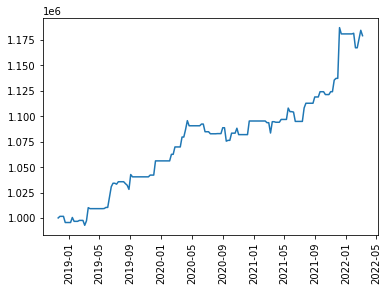

In [155]:
import math

length_of_training = 45
iteration = Rows-length_of_training
length_of_testing = 3
entry_values = [1]#, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
capital = 1000000

instruments = list(data.columns)
n = len(instruments)
m = len(data.iloc[:, 0])

# The excel draft.
excel = {'# of training data': [],
          'Training begins': [],
          'Training ends\nTesting begins': [],
          'Testing ends': [],
          'Toplam maliyet': [],
          'Kasa': [],
          'Portföy adedi': [],
          'Kullanılan para': [],
          'Atıl Para': [],
          'Portföy Açılış Endeksi': [],
          'Portföy Kapanış Endeksi': [],
          'Fark': [],
          'P&L': [],
          'P&L%': [],
          'RiskOptima Portföy Değeri': []
          }

# Add each instrument's special columns.
# These are to be turned to multicolumns.
extra_cols = ['Katsayı', 'Portföy Açma', 'Portföy Kapama', 'Maliyet']
for col in extra_cols:
  for instrument in instruments:
    excel[col + ' ' + instrument] = list()




# Get the coefficients, calculate the opening indices.
# If the last index is positive, then invert the coefficients, thus the opening indices.
# If the last index is below the entry*std_dev line then buy.
# TODO: The code currently works with one week by breaking after the first iteration.
#       This needs to be enhanced to multiple weeks.
for entry in entry_values:
  for length_of_testing in range(1, 2):
    #f, axs = plt.subplots(4, figsize=(10, 10))
    profit_losses = []
    trades = 0
    for i in range(0, m - length_of_training - length_of_testing - 1, length_of_testing):
      if i == iteration*length_of_testing:
        break
      # Calculate the coefficients.
      named_coefficients = get_coefficients(data, i, i + length_of_training, set()) # the coefficient dictionary
      if type(named_coefficients) == bool:
        j = i
        while type(named_coefficients) == bool and j > 0:
          j = j - 1
          #print('No valid models for the training period', j, 'to', i + length_of_training)
          named_coefficients = get_coefficients(data, j, i + length_of_training, set()) # the coefficient dictionary
          continue
        if j == 0:
          #print('No valid models for the training period starting at', i)
          #print('--------------------------------------------------------')
          result = {'# of training data': length_of_training,
            'Training begins': level_data.index[i],
            'Training ends\nTesting begins': level_data.index[i + length_of_training],
            'Testing ends': level_data.index[i + length_of_training + length_of_testing],
            'Toplam maliyet': 0,
            'Kasa': capital,
            'Portföy adedi': 0,
            'Kullanılan para': 0,
            'Atıl Para': capital,
            'Portföy Açılış Endeksi': opening_index,
            'Portföy Kapanış Endeksi': closing_index,
            'Fark': 0,
            'P&L': 0,
            'P&L%': 0, # ratio of profit or loss to the overall money
            'RiskOptima Portföy Değeri': capital
          }
          for column_name in result.keys(): # move the results to excel
            excel[column_name].append(result[column_name])

          extra_cols_dict = {'Katsayı': coefficients, 'Portföy Açma': opening, 'Portföy Kapama': closing, 'Maliyet': cost_of_opening}
          for col in extra_cols_dict:
            for instrument in instruments: # for those columns that are to be turned into multicolumns, appending is somewhat manual
              excel[col + ' ' + instrument].append(extra_cols_dict[col][instruments.index(instrument)])

          capital = result['RiskOptima Portföy Değeri'] # the new capital
          continue

      coefficients = [named_coefficients.get(instrument, 0) for instrument in instruments] # copy the dictionary, setting 0 those dropped
      print('Entry =', entry, 'length =', length_of_testing, 'day', i, 'coefficients:', coefficients)
      opening_indices = []
      for j in range(i, i + length_of_training):
        opening = data.iloc[j, :] # prices
        opening_indices.append(numpy.dot(opening, coefficients)) # calculate the account opening index
      std_dev = numpy.std(opening_indices)
      mean = numpy.mean(opening_indices)
      if opening_indices[-1] > mean:
        #print("Inverting the coefficients at iter =", i)
        coefficients = [-c for c in coefficients]
        opening_indices = [-o for o in opening_indices]
      mean = numpy.mean(opening_indices)

      #for j in range(len(opening_indices)):
      #  print('Day', j, ':', opening_indices[j])

      if i == iteration - 1:
        plt.plot(opening_indices)
        mean_line = [mean for j in range(len(opening_indices))]
        plt.plot(mean_line)
        bottom_line = [z - entry*std_dev for z in mean_line]
        plt.plot(bottom_line)
        top_line = [z + entry*std_dev for z in mean_line]
        plt.plot(top_line)
        plt.show()
        print(entry, 'times the standard deviation:', entry*std_dev)
      


      opening = level_data.iloc[i + length_of_training, :] # prices at the day testing begins

      cost_of_opening = [opening[i] * abs(coefficients[i]) for i in range(n)] # the cost of opening one account for each instrument
      cost = sum(cost_of_opening) # the total cost of opening an account

      while cost > 100:
        coefficients = [c / 10 for c in coefficients]
        cost_of_opening = [c / 10 for c in cost_of_opening]
        cost = cost / 10

      opening_index = numpy.dot(opening, coefficients) # calculate the account opening index

      closing = level_data.iloc[i + length_of_training + length_of_testing, :] # prices at the day testing ends
      closing_index = numpy.dot(closing, coefficients) # calculate the account closing index

      difference = closing_index - opening_index # profit or loss per account

      count = capital // cost # number of accounts that can be created

      # Calculate profit or loss.
      profit_and_loss = difference * count # profit or loss multiplied with the number of accounts
      #print('PL:', profit_and_loss)
      profit_losses.append(profit_and_loss)
      trades = trades + 1
      #print('--------------------------------------------------------')
      # Decide whether the trade will take place.
      if opening_indices[-1] >= mean-entry*std_dev:
        print('No trade at iter =', i)
        #print('--------------------------------------------------------')
        result = {'# of training data': length_of_training,
          'Training begins': level_data.index[i],
          'Training ends\nTesting begins': level_data.index[i + length_of_training],
          'Testing ends': level_data.index[i + length_of_training + length_of_testing],
          'Toplam maliyet': 0,
          'Kasa': capital,
          'Portföy adedi': 0,
          'Kullanılan para': 0,
          'Atıl Para': capital,
          'Portföy Açılış Endeksi': opening_index,
          'Portföy Kapanış Endeksi': closing_index,
          'Fark': 0,
          'P&L': 0,
          'P&L%': 0, # ratio of profit or loss to the overall money
          'RiskOptima Portföy Değeri': capital
          }
        for column_name in result.keys(): # move the results to excel
          excel[column_name].append(result[column_name])

        extra_cols_dict = {'Katsayı': coefficients, 'Portföy Açma': opening, 'Portföy Kapama': closing, 'Maliyet': cost_of_opening}
        for col in extra_cols_dict:
          for instrument in instruments: # for those columns that are to be turned into multicolumns, appending is somewhat manual
            excel[col + ' ' + instrument].append(extra_cols_dict[col][instruments.index(instrument)])

        capital = result['RiskOptima Portföy Değeri'] # the new capital
        continue
      # Record the results in a dictionary to be appended to the respectice column in excel.
      result = {'# of training data': length_of_training,
                'Training begins': level_data.index[i],
                'Training ends\nTesting begins': level_data.index[i + length_of_training],
                'Testing ends': level_data.index[i + length_of_training + length_of_testing],
                'Toplam maliyet': cost,
                'Kasa': capital,
                'Portföy adedi': count,
                'Kullanılan para': count * cost,
                'Atıl Para': capital - count * cost,
                'Portföy Açılış Endeksi': opening_index,
                'Portföy Kapanış Endeksi': closing_index,
                'Fark': difference,
                'P&L': profit_and_loss,
                'P&L%': profit_and_loss / capital * 100, # ratio of profit or loss to the overall money
                'RiskOptima Portföy Değeri': capital + profit_and_loss
                }

      for column_name in result.keys(): # move the results to excel
        excel[column_name].append(result[column_name])

      extra_cols_dict = {'Katsayı': coefficients, 'Portföy Açma': opening, 'Portföy Kapama': closing, 'Maliyet': cost_of_opening}
      for col in extra_cols_dict:
        for instrument in instruments: # for those columns that are to be turned into multicolumns, appending is somewhat manual
          excel[col + ' ' + instrument].append(extra_cols_dict[col][instruments.index(instrument)])

      capital = result['RiskOptima Portföy Değeri'] # the new capital
    if len(profit_losses) > 0:
      mean_pl = numpy.mean(profit_losses)
      std_pl = numpy.std(profit_losses)
      sharpe = mean_pl / std_pl * math.sqrt(360)
      print('Sharpe ratio for entry value =', entry,
            'and testing length =', length_of_testing, ':',
            sharpe, 'where', trades, 'number of trades occured.')
      print("Capital after trades=",excel["Kasa"][-1])
      print("P%L=",(excel["Kasa"][-1]-excel["Kasa"][0])/excel["Kasa"][0]*100,"%")
      #axs[0].plot(sharpe)
      #axs[1].plot(mean_pl)
      #axs[2].plot(std_pl)
      #axs[3].plot(trades)
      #plt.show()

pandas.DataFrame(excel).to_excel('report.xlsx') # write to excel

plt.plot(excel['Testing ends'], excel['Kasa'])
plt.xticks(rotation = 90)
plt.savefig('graph.png')
plt.show()

wb = openpyxl.load_workbook('report.xlsx')
ws = wb.active
img = openpyxl.drawing.image.Image('graph.png')
cols = 15 + 4 * n
img.anchor = chr(ord('A') + (cols - 25) // 25) + chr(ord('A') + cols % 25) + '1'
ws.add_image(img)
wb.save('out.xlsx')